In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from tqdm import tqdm
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from scipy.ndimage.filters import gaussian_filter, uniform_filter
from scipy import stats
from sklearn.linear_model import SGDRegressor
tqdm.pandas()
import cmocean
import matplotlib as mpl

c:\Users\Matt\.conda\envs\astronomy\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
PATH_RAW = 'D:/Workshop/PhD/Data/ViaLactea/PPMAP_Results/'
PATH_64x85 = 'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_rejigged_fulltile/'
PATH_32x17 = 'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_rejigged_fulltile_64pxwindow/'
PATH_32x85 = 'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/32px_rejigged_fulltile/'

In [3]:
no_files = len(os.listdir(PATH_32x17+'DataCubes'))
no_files

163

In [4]:
def average_field(field, filter_size, norm = False):
    field_noNANs = np.nan_to_num(field)
    mask = field_noNANs.copy()
    mask[field_noNANs==0] = np.nan
    mask[field_noNANs!=0] = 1
    
    avg_field = uniform_filter(field_noNANs, size=filter_size, mode='mirror')*mask
    
    if norm:
        return np.log10(avg_field)
    return avg_field

def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

In [5]:
#Calculate bins
H_min, H_max = -0.25, 1.25
S_min, S_max = -0.25, 3.5

H_bins_2d = np.linspace(H_min,H_max,201)
S_bins_2d = np.linspace(S_min,S_max,201)

normalise = True

Sigma_min = 0.4
Sigma_max = 3.5

Sigma_bins_2d = np.linspace(Sigma_min, Sigma_max,201)

In [6]:
# Calculate bins
hist_a = np.zeros((200,200))
hist_b = np.zeros((200,200))
hist_c = np.zeros((200,200))
hist_d = np.zeros((200,200))
hist_e = np.zeros((200,200))
hist_f = np.zeros((200,200))

for i in tqdm(range(no_files)):
    cube_64x85 = pickle.load(open(f'{PATH_64x85}/DataCubes/{os.listdir(PATH_64x85+"DataCubes")[i]}','rb'))
    cube_32x85 = pickle.load(open(f'{PATH_32x85}/DataCubes/{os.listdir(PATH_32x85+"DataCubes")[i]}','rb'))
    cube_32x17 = pickle.load(open(f'{PATH_32x17}/DataCubes/{os.listdir(PATH_32x17+"DataCubes")[i]}','rb'))

    temp_df = pd.DataFrame()
    temp_df['H_64x85'] = np.pad(cube_64x85[1],((32,31),(32,31)), 'constant', constant_values = np.nan).flatten()
    temp_df['H_32x85'] = np.pad(cube_32x85[1],((16,15),(16,15)), 'constant', constant_values = np.nan).flatten()
    temp_df['H_32x17'] = np.pad(cube_32x17[1],((32,31),(32,31)), 'constant', constant_values = np.nan).flatten()
    temp_df['S_64x85'] = np.pad(cube_64x85[2],((32,31),(32,31)), 'constant', constant_values = np.nan).flatten()
    temp_df['S_32x85'] = np.pad(cube_32x85[2],((16,15),(16,15)), 'constant', constant_values = np.nan).flatten()
    temp_df['S_32x17'] = np.pad(cube_32x17[2],((32,31),(32,31)), 'constant', constant_values = np.nan).flatten()
    temp_df['col_dens'] = average_field(cube_64x85[0], 64, normalise).flatten()
    temp_df = temp_df.dropna()

    hist_a_temp, jnk, jnk = np.histogram2d(temp_df['col_dens'],temp_df['H_32x85'],bins=[Sigma_bins_2d,H_bins_2d])
    hist_b_temp, jnk, jnk = np.histogram2d(temp_df['col_dens'],temp_df['H_32x17'],bins=[Sigma_bins_2d,H_bins_2d])
    hist_c_temp, jnk, jnk = np.histogram2d(temp_df['col_dens'],temp_df['H_64x85'],bins=[Sigma_bins_2d,H_bins_2d])
    hist_d_temp, jnk, jnk = np.histogram2d(temp_df['col_dens'],temp_df['S_32x85'],bins=[Sigma_bins_2d,S_bins_2d])
    hist_e_temp, jnk, jnk = np.histogram2d(temp_df['col_dens'],temp_df['S_32x17'],bins=[Sigma_bins_2d,S_bins_2d])
    hist_f_temp, jnk, jnk = np.histogram2d(temp_df['col_dens'],temp_df['S_64x85'],bins=[Sigma_bins_2d,S_bins_2d])

    hist_a += hist_a_temp
    hist_b += hist_b_temp
    hist_c += hist_c_temp
    hist_d += hist_d_temp
    hist_e += hist_e_temp
    hist_f += hist_f_temp

100%|██████████| 163/163 [10:39<00:00,  3.93s/it]


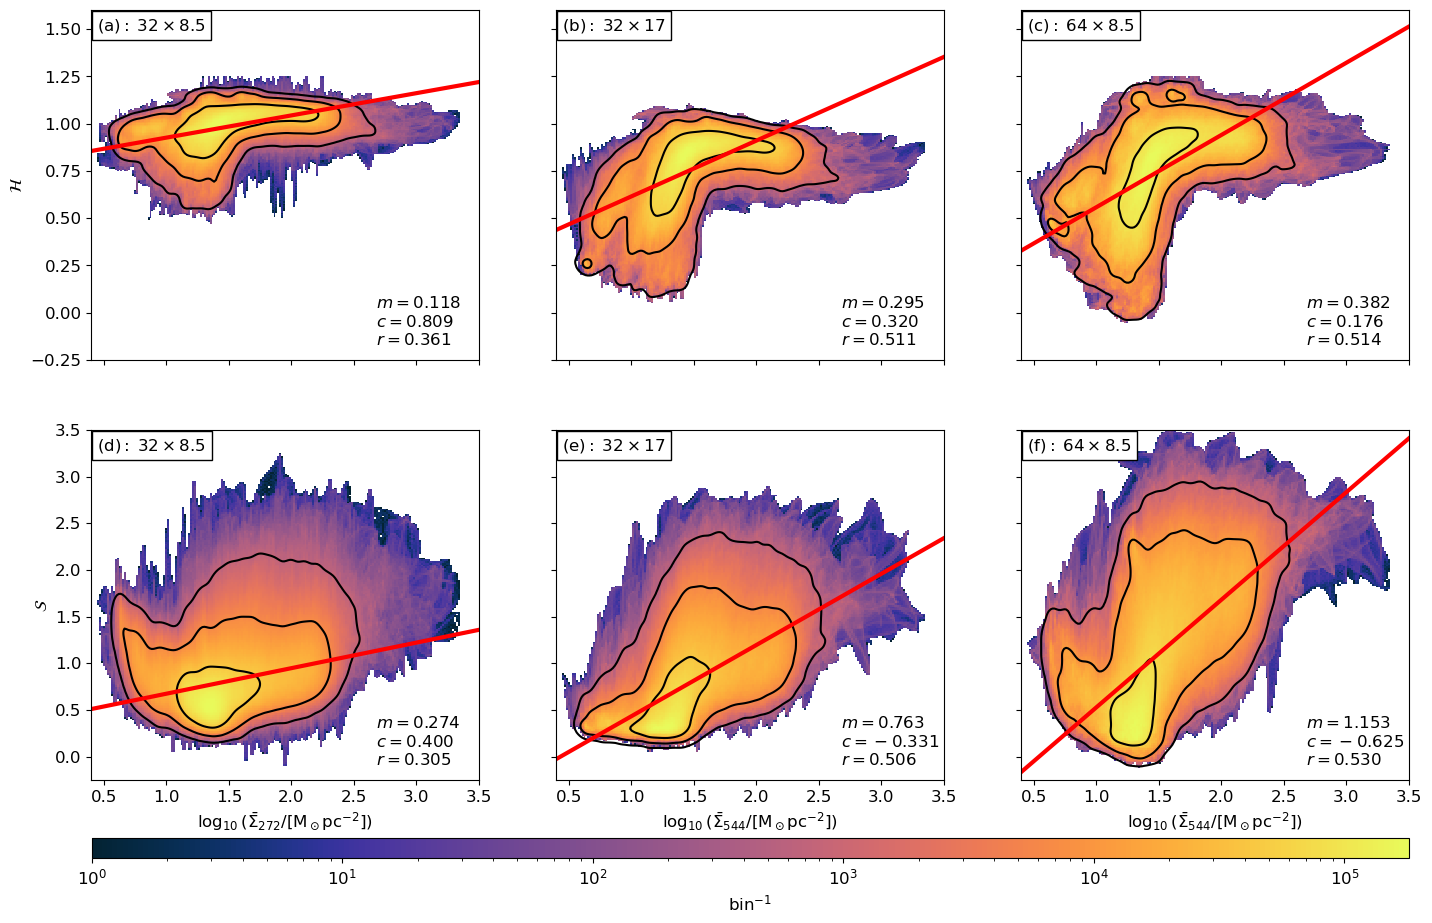

In [12]:
x = 0.015
y = 0.942
sigma = 2

plt.rcParams.update({'font.size': 12})
f,ax = plt.subplots(2,3, figsize=(17,10), sharex = True, sharey = 'row')


ax[0,0].pcolormesh(Sigma_bins_2d,H_bins_2d,hist_a.T, cmap=cmocean.cm.thermal, norm=mpl.colors.LogNorm())
contours = ax[0,0].contour(gaussian_filter(hist_a.transpose(),sigma), 
                extent = [Sigma_min,Sigma_max,H_min,H_max],
                levels = [1000,10000,70000],
                           colors='k'
               )
ax[0,0].set_ylabel(r'$\mathcal{H}}$')
ax[0,0].text(x, y, r'$\mathrm{(a):}\;32\times 8.5$', transform=ax[0,0].transAxes,bbox = dict(facecolor='white'))


ax[0,1].pcolormesh(Sigma_bins_2d,H_bins_2d,hist_b.T, cmap=cmocean.cm.thermal, norm=mpl.colors.LogNorm())
contours = ax[0,1].contour(gaussian_filter(hist_b.transpose(),sigma), 
                extent = [Sigma_min,Sigma_max,H_min,H_max],
                levels = [1000,10000,70000],
                           colors='k'
               )
ax[0,1].text(x, y, r'$\mathrm{(b):}\;32\times 17$', transform=ax[0,1].transAxes,bbox = dict(facecolor='white'))


ax[0,2].pcolormesh(Sigma_bins_2d,H_bins_2d,hist_c.T, cmap=cmocean.cm.thermal, norm=mpl.colors.LogNorm())
contours = ax[0,2].contour(gaussian_filter(hist_c.transpose(),sigma), 
                extent = [Sigma_min,Sigma_max,H_min,H_max],
                levels = [1000,10000,70000],
                           colors='k'
               )
ax[0,2].text(x, y, r'$\mathrm{(c):}\;64\times 8.5$', transform=ax[0,2].transAxes,bbox = dict(facecolor='white'))

xpoints = np.linspace(Sigma_min,Sigma_max,3)
H_bins_2d_m = (H_bins_2d[1:] + H_bins_2d[:-1]) / 2
Sigma_bins_2d_m = (Sigma_bins_2d[1:] + Sigma_bins_2d[:-1]) / 2
Sigma_bins_n, H_bins_n = np.meshgrid(Sigma_bins_2d_m, H_bins_2d_m)

df = pd.DataFrame({
    'Sigma': Sigma_bins_n.ravel(),
    'H': H_bins_n.ravel(),
    'w': np.sqrt(hist_a.T.ravel())
})
df = df.replace([np.inf,-np.inf], np.nan)
df = df.dropna()

p_a = np.polyfit(df['Sigma'], df['H'], 1, w=df['w'])
ypoints = np.polyval(p_a, xpoints)

ax[0,0].plot(xpoints,ypoints, c='r', linewidth=3)
ax[0,0].text(x+0.72, y-0.95, fr'''
$m={round(p_a[0],3):.3f}$
$c={round(p_a[1],3):.3f}$
$r={round(corr(df["Sigma"], df["H"], df["w"]),3):03}$
''', transform=ax[0,0].transAxes)

df = pd.DataFrame({
    'Sigma': Sigma_bins_n.ravel(),
    'H': H_bins_n.ravel(),
    'w': np.sqrt(hist_b.T.ravel())
})
df = df.replace([np.inf,-np.inf], np.nan)
df = df.dropna()

p_b = np.polyfit(df['Sigma'], df['H'], 1, w=df['w'])
ypoints = np.polyval(p_b, xpoints)

ax[0,1].plot(xpoints,ypoints, c='r', linewidth=3)
ax[0,1].text(x+0.72, y-0.95, fr'''
$m={round(p_b[0],3):.3f}$
$c={round(p_b[1],3):.3f}$
$r={round(corr(df["Sigma"], df["H"], df["w"]),3):03}$
''', transform=ax[0,1].transAxes)

df = pd.DataFrame({
    'Sigma': Sigma_bins_n.ravel(),
    'H': H_bins_n.ravel(),
    'w': np.sqrt(hist_c.T.ravel())
})
df = df.replace([np.inf,-np.inf], np.nan)
df = df.dropna()

p_c = np.polyfit(df['Sigma'], df['H'], 1, w=df['w'])
ypoints = np.polyval(p_c, xpoints)

ax[0,2].plot(xpoints,ypoints, c='r', linewidth=3)
ax[0,2].text(x+0.72, y-0.95, fr'''
$m={round(p_c[0],3):.3f}$
$c={round(p_c[1],3):.3f}$
$r={round(corr(df["Sigma"], df["H"], df["w"]),3):03}$
''', transform=ax[0,2].transAxes)


img_d = ax[1,0].pcolormesh(Sigma_bins_2d,S_bins_2d,hist_d.T, cmap=cmocean.cm.thermal, norm=mpl.colors.LogNorm())
contours = ax[1,0].contour(gaussian_filter(hist_d.transpose(),sigma), 
                extent = [Sigma_min,Sigma_max,S_min,S_max],
                levels = [1000,10000,70000],
                           colors='k'
               )
ax[1,0].set_xlabel(r'$\log_{10}(\bar{\Sigma}_{272}/ [\rm{M}_\odot \rm{pc}^{-2}])$')
ax[1,0].set_ylabel(r'$\mathcal{S}}$')
ax[1,0].text(x, y, r'$\mathrm{(d):}\;32\times 8.5$', transform=ax[1,0].transAxes,bbox = dict(facecolor='white'))

img_e = ax[1,1].pcolormesh(Sigma_bins_2d,S_bins_2d,hist_e.T, cmap=cmocean.cm.thermal, norm=mpl.colors.LogNorm())
contours = ax[1,1].contour(gaussian_filter(hist_e.transpose(),sigma), 
                extent = [Sigma_min,Sigma_max,S_min,S_max],
                levels = [1000,10000,70000],
                           colors='k'
               )
ax[1,1].set_xlabel(r'$\log_{10}(\bar{\Sigma}_{544}/ [\rm{M}_\odot \rm{pc}^{-2}])$')
ax[1,1].text(x, y, r'$\mathrm{(e):}\;32\times 17$', transform=ax[1,1].transAxes,bbox = dict(facecolor='white'))

img_f = ax[1,2].pcolormesh(Sigma_bins_2d,S_bins_2d,hist_f.T, cmap=cmocean.cm.thermal, norm=mpl.colors.LogNorm())
contours = ax[1,2].contour(gaussian_filter(hist_f.transpose(),sigma), 
                extent = [Sigma_min,Sigma_max,S_min,S_max],
                levels = [1000,10000,70000],
                           colors='k'
               )
ax[1,2].set_xlabel(r'$\log_{10}(\bar{\Sigma}_{544}/ [\rm{M}_\odot \rm{pc}^{-2}])$')
ax[1,2].text(x, y, r'$\mathrm{(f):}\;64\times 8.5$', transform=ax[1,2].transAxes,bbox = dict(facecolor='white'))

xpoints = np.linspace(Sigma_min,Sigma_max,3)
S_bins_2d_m = (S_bins_2d[1:] + S_bins_2d[:-1]) / 2
Sigma_bins_2d_m = (Sigma_bins_2d[1:] + Sigma_bins_2d[:-1]) / 2
Sigma_bins_n, S_bins_n = np.meshgrid(Sigma_bins_2d_m, S_bins_2d_m)

df = pd.DataFrame({
    'Sigma': Sigma_bins_n.ravel(),
    'S': S_bins_n.ravel(),
    'w': np.sqrt(hist_d.T.ravel())
})
df = df.replace([np.inf,-np.inf], np.nan)
df = df.dropna()

p_d = np.polyfit(df['Sigma'], df['S'], 1, w=df['w'])
ypoints = np.polyval(p_d, xpoints)

ax[1,0].plot(xpoints,ypoints, c='r', linewidth=3)
ax[1,0].text(x+0.72, y-0.95, fr'''
$m={round(p_d[0],3):.3f}$
$c={round(p_d[1],3):.3f}$
$r={round(corr(df["Sigma"], df["S"], df["w"]),3):03}$
''', transform=ax[1,0].transAxes)


df = pd.DataFrame({
    'Sigma': Sigma_bins_n.ravel(),
    'S': S_bins_n.ravel(),
    'w': np.sqrt(hist_e.T.ravel())
})
df = df.dropna()

p_e = np.polyfit(df['Sigma'], df['S'], 1, w=df['w'])
ypoints = np.polyval(p_e, xpoints)
ax[1,1].plot(xpoints,ypoints, c='r', linewidth=3)
ax[1,1].text(x+0.72, y-0.95, fr'''
$m={round(p_e[0],3):.3f}$
$c={round(p_e[1],3):.3f}$
$r={round(corr(df["Sigma"], df["S"], df["w"]),3):03}$
''', transform=ax[1,1].transAxes)

df = pd.DataFrame({
    'Sigma': Sigma_bins_n.ravel(),
    'S': S_bins_n.ravel(),
    'w': np.sqrt(hist_f.T.ravel())
})
df = df.dropna()

p_f = np.polyfit(df['Sigma'], df['S'], 1, w=df['w'])
ypoints = np.polyval(p_f, xpoints)
ax[1,2].plot(xpoints,ypoints, c='r', linewidth=3)
ax[1,2].text(x+0.72, y-0.95, fr'''
$m={round(p_f[0],3):.3f}$
$c={round(p_f[1],3):.3f}$
$r={round(corr(df["Sigma"], df["S"], df["w"]),3):.3f}$
''', transform=ax[1,2].transAxes)

cbaxes = f.add_axes([0.1252, 0.032, 0.775, 0.02]) 
cb = plt.colorbar(img_f,orientation="horizontal", cax = cbaxes, label=r'$\mathrm{bin}^{-1}$')

ax[1,0].set_ylim(S_min,S_max)

plt.savefig('D:\Workshop\PhD\Papers\HiGal paper\Images/HSvnormofSigmaAllFits.png',bbox_inches="tight")
plt.show()

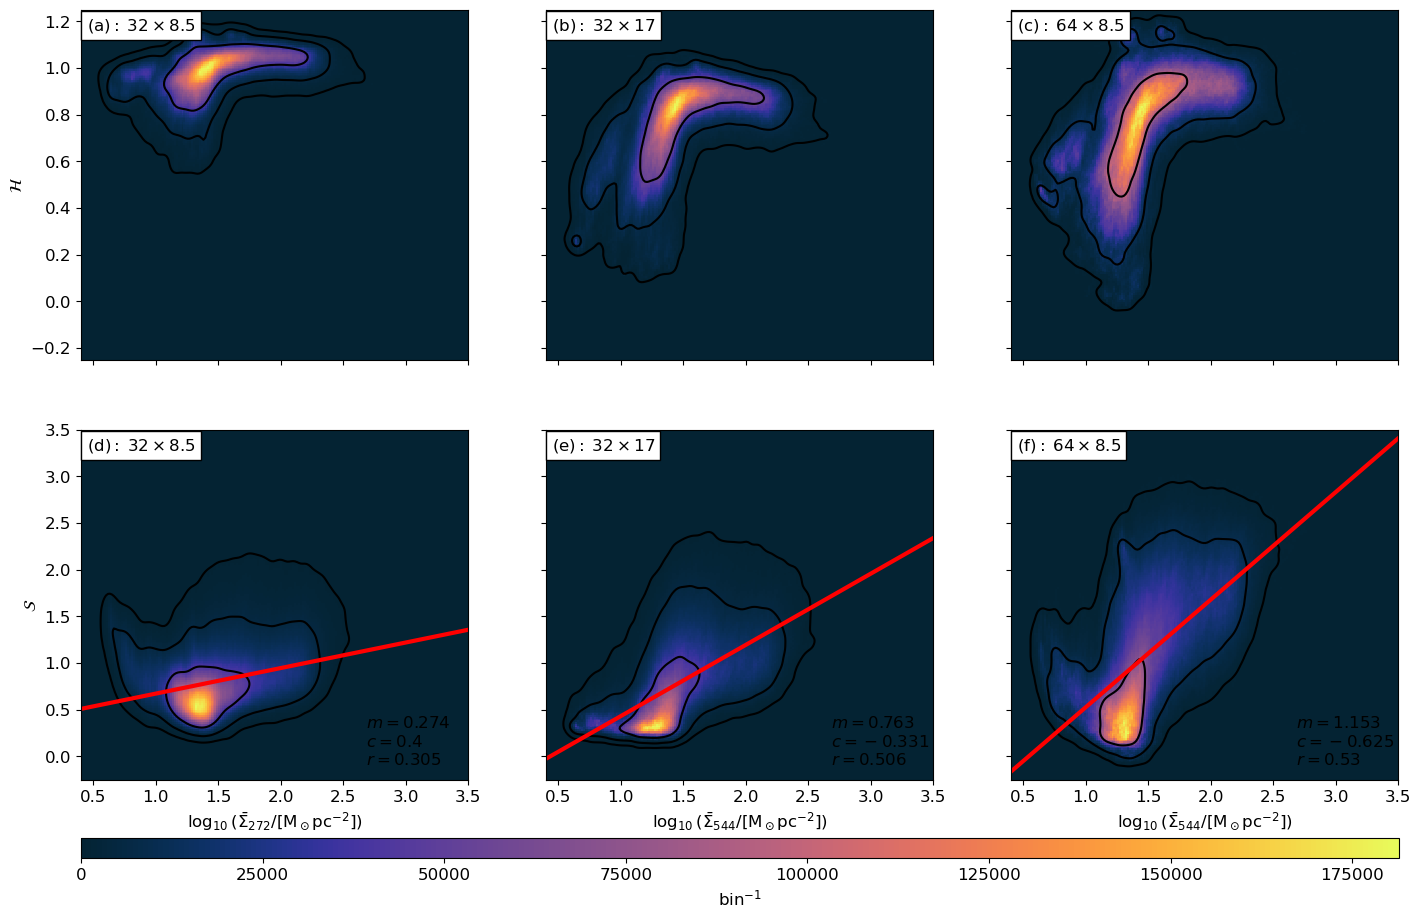

In [8]:
x = 0.015
y = 0.942
sigma = 2

plt.rcParams.update({'font.size': 12})
f,ax = plt.subplots(2,3, figsize=(17,10), sharex = True, sharey = 'row')


ax[0,0].pcolormesh(Sigma_bins_2d,H_bins_2d,hist_a.T, cmap=cmocean.cm.thermal)
contours = ax[0,0].contour(gaussian_filter(hist_a.transpose(),sigma), 
                extent = [Sigma_min,Sigma_max,H_min,H_max],
                levels = [1000,10000,70000],
                           colors='k'
               )
ax[0,0].set_ylabel(r'$\mathcal{H}}$')
ax[0,0].text(x, y, r'$\mathrm{(a):}\;32\times 8.5$', transform=ax[0,0].transAxes,bbox = dict(facecolor='white'))


ax[0,1].pcolormesh(Sigma_bins_2d,H_bins_2d,hist_b.T, cmap=cmocean.cm.thermal)
contours = ax[0,1].contour(gaussian_filter(hist_b.transpose(),sigma), 
                extent = [Sigma_min,Sigma_max,H_min,H_max],
                levels = [1000,10000,70000],
                           colors='k'
               )
ax[0,1].text(x, y, r'$\mathrm{(b):}\;32\times 17$', transform=ax[0,1].transAxes,bbox = dict(facecolor='white'))


ax[0,2].pcolormesh(Sigma_bins_2d,H_bins_2d,hist_c.T, cmap=cmocean.cm.thermal)
contours = ax[0,2].contour(gaussian_filter(hist_c.transpose(),sigma), 
                extent = [Sigma_min,Sigma_max,H_min,H_max],
                levels = [1000,10000,70000],
                           colors='k'
               )
ax[0,2].text(x, y, r'$\mathrm{(c):}\;64\times 8.5$', transform=ax[0,2].transAxes,bbox = dict(facecolor='white'))


img_d = ax[1,0].pcolormesh(Sigma_bins_2d,S_bins_2d,hist_d.T, cmap=cmocean.cm.thermal)
contours = ax[1,0].contour(gaussian_filter(hist_d.transpose(),sigma), 
                extent = [Sigma_min,Sigma_max,S_min,S_max],
                levels = [1000,10000,70000],
                           colors='k'
               )
ax[1,0].set_xlabel(r'$\log_{10}(\bar{\Sigma}_{272}/ [\rm{M}_\odot \rm{pc}^{-2}])$')
ax[1,0].set_ylabel(r'$\mathcal{S}}$')
ax[1,0].text(x, y, r'$\mathrm{(d):}\;32\times 8.5$', transform=ax[1,0].transAxes,bbox = dict(facecolor='white'))

img_e = ax[1,1].pcolormesh(Sigma_bins_2d,S_bins_2d,hist_e.T, cmap=cmocean.cm.thermal)
contours = ax[1,1].contour(gaussian_filter(hist_e.transpose(),sigma), 
                extent = [Sigma_min,Sigma_max,S_min,S_max],
                levels = [1000,10000,70000],
                           colors='k'
               )
ax[1,1].set_xlabel(r'$\log_{10}(\bar{\Sigma}_{544}/ [\rm{M}_\odot \rm{pc}^{-2}])$')
ax[1,1].text(x, y, r'$\mathrm{(e):}\;32\times 17$', transform=ax[1,1].transAxes,bbox = dict(facecolor='white'))

img_f = ax[1,2].pcolormesh(Sigma_bins_2d,S_bins_2d,hist_f.T, cmap=cmocean.cm.thermal)
contours = ax[1,2].contour(gaussian_filter(hist_f.transpose(),sigma), 
                extent = [Sigma_min,Sigma_max,S_min,S_max],
                levels = [1000,10000,70000],
                           colors='k'
               )
ax[1,2].set_xlabel(r'$\log_{10}(\bar{\Sigma}_{544}/ [\rm{M}_\odot \rm{pc}^{-2}])$')
ax[1,2].text(x, y, r'$\mathrm{(f):}\;64\times 8.5$', transform=ax[1,2].transAxes,bbox = dict(facecolor='white'))

xpoints = np.linspace(Sigma_min,Sigma_max,3)
S_bins_2d_m = (S_bins_2d[1:] + S_bins_2d[:-1]) / 2
Sigma_bins_2d_m = (Sigma_bins_2d[1:] + Sigma_bins_2d[:-1]) / 2
Sigma_bins_n, S_bins_n = np.meshgrid(Sigma_bins_2d_m, S_bins_2d_m)

df = pd.DataFrame({
    'Sigma': Sigma_bins_n.ravel(),
    'S': S_bins_n.ravel(),
    'w': np.sqrt(hist_d.T.ravel())
})
df = df.dropna()

p_d = np.polyfit(df['Sigma'], df['S'], 1, w=df['w'])
ypoints = np.polyval(p_d, xpoints)

ax[1,0].plot(xpoints,ypoints, c='r', linewidth=3)
ax[1,0].text(x+0.72, y-0.95, fr'''
$m={round(p_d[0],3)}$
$c={round(p_d[1],3)}$
$r={round(corr(df["Sigma"], df["S"], df["w"]),3)}$
''', transform=ax[1,0].transAxes)


df = pd.DataFrame({
    'Sigma': Sigma_bins_n.ravel(),
    'S': S_bins_n.ravel(),
    'w': np.sqrt(hist_e.T.ravel())
})
df = df.dropna()

p_e = np.polyfit(df['Sigma'], df['S'], 1, w=df['w'])
ypoints = np.polyval(p_e, xpoints)
ax[1,1].plot(xpoints,ypoints, c='r', linewidth=3)
ax[1,1].text(x+0.72, y-0.95, fr'''
$m={round(p_e[0],3)}$
$c={round(p_e[1],3)}$
$r={round(corr(df["Sigma"], df["S"], df["w"]),3)}$
''', transform=ax[1,1].transAxes)

df = pd.DataFrame({
    'Sigma': Sigma_bins_n.ravel(),
    'S': S_bins_n.ravel(),
    'w': np.sqrt(hist_f.T.ravel())
})
df = df.dropna()

p_f = np.polyfit(df['Sigma'], df['S'], 1, w=df['w'])
ypoints = np.polyval(p_f, xpoints)
ax[1,2].plot(xpoints,ypoints, c='r', linewidth=3)
ax[1,2].text(x+0.72, y-0.95, fr'''
$m={round(p_f[0],3)}$
$c={round(p_f[1],3)}$
$r={round(corr(df["Sigma"], df["S"], df["w"]),3)}$
''', transform=ax[1,2].transAxes)

cbaxes = f.add_axes([0.1252, 0.032, 0.775, 0.02]) 
cb = plt.colorbar(img_f,orientation="horizontal", cax = cbaxes, label=r'$\mathrm{bin}^{-1}$')

ax[1,0].set_ylim(S_min,S_max)

plt.savefig('D:\Workshop\PhD\Papers\HiGal paper\Images/HSvnormofSigma.png',bbox_inches="tight")
plt.show()